# QNN4EO: a quantum convolutional neural network for satellite data classification

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os

## Load the dataset

The dataset is loaded through the DatasetHandler class.

In [34]:
from DatasetHandler import DatasetHandler

### 1. Initialize the dataset handler

The dataset handler is initialized using the root path of the dataset. In this cases the root path is  *EuroSAT*, this folder contains a sub-folder for each class as printed below.

In [35]:
dataset_root_path = 'EuroSAT'
datasetHandler = DatasetHandler(dataset_root_path)
datasetHandler.print_classes()

Classes: 
     Class 0 -> EuroSAT/Forest
     Class 1 -> EuroSAT/River
     Class 2 -> EuroSAT/Highway
     Class 3 -> EuroSAT/AnnualCrop
     Class 4 -> EuroSAT/SeaLake
     Class 5 -> EuroSAT/HerbaceousVegetation
     Class 6 -> EuroSAT/Industrial
     Class 7 -> EuroSAT/Residential
     Class 8 -> EuroSAT/PermanentCrop
     Class 9 -> EuroSAT/Pasture


### 2. Select the two classes for the binary classification
In order to run the binary classification, the used should select two classes from the dataset

In [26]:
class_1 = int(input('Class 1 [0-9]: '))
print('\t\t',datasetHandler.classes[class_1], '\n')

class_2 = int(input('Class 2 [0-9]: '))
print('\t\t',datasetHandler.classes[class_2], '\n')

classes_name = []
classes_name.append(datasetHandler.classes[class_1].split('/')[-1])
classes_name.append(datasetHandler.classes[class_2].split('/')[-1])

Class 1 [0-9]:  0


		 EuroSAT/Forest 



Class 2 [0-9]:  1


		 EuroSAT/River 



### 3. Load paths and labels
After the selection of the two classes, the Dataset Handler loads images paths and images labels for both the two classes

In [27]:
imgs_path, imgs_label = datasetHandler.load_paths_labels(classes = [datasetHandler.classes[class_1], datasetHandler.classes[class_2]])

print('Dataset images: ', len(imgs_path))
print('Dataset labels: ', len(imgs_label))
print('Dataset sample -> image path: ', imgs_path[0], ' image label', imgs_label[0])

Dataset images:  5500
Dataset labels:  5500
Dataset sample -> image path:  EuroSAT/Forest/Forest_2182.jpg  image label [1. 0.]


### 4. Trainining-Validation split
The paths and labels are then divided randomly in training and validation datasets

In [7]:
train_images, train_labels, val_images, val_labels = datasetHandler.train_validation_split(imgs_path, imgs_label, split_factor = 0.2)
print('Training images: ',  train_images.shape)
print('Training labels: ',  train_labels.shape)
print('Validatiom images: ',  val_images.shape)
print('Validation labels: ',  val_labels.shape)

Training images:  (4400,)
Training labels:  (4400, 2)
Validatiom images:  (1100,)
Validation labels:  (1100, 2)


### 5. Display a sample of the dataset
In order to visualize the images and lables of the two classes selected, the utility *plotDataset* can be used to plot a sample of the training/validation dataset.

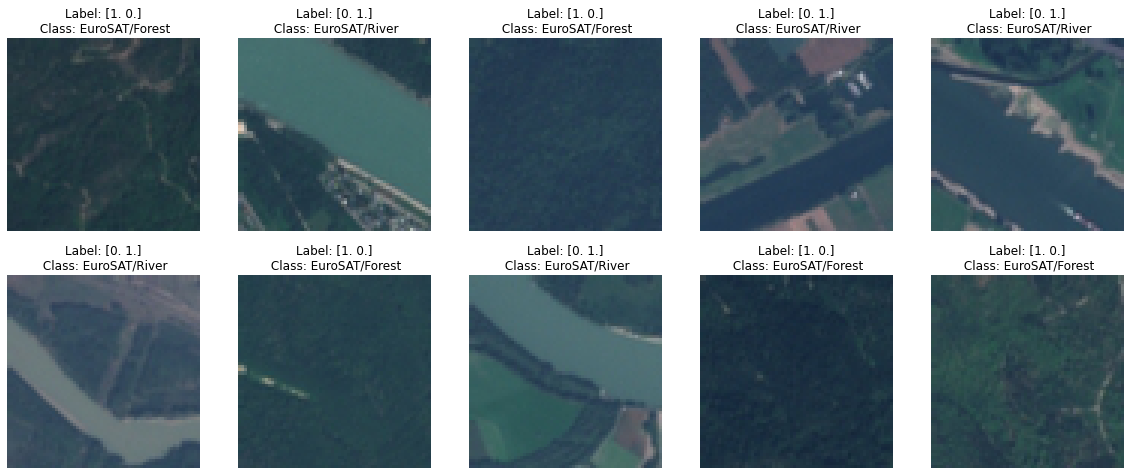

In [28]:
from utils import plotDataset
plotDataset(train_images, train_labels, datasetHandler.classes, columns = 5, rows = 2)

## CNN classifier

In [10]:
from CNN_Classifier import CNN_Classifier

### 1. Initialize the CNN model

In [11]:
img_shape = plt.imread(train_images[0]).shape
n_classes = train_labels.shape[1]

cnn = CNN_Classifier(img_shape = img_shape, n_classes = n_classes)

### 2. Train the CNN model

In [ ]:
batch_size = 1
epochs = 20
train_generator = datasetHandler.cnn_data_loader(train_images, train_labels, batch_size = batch_size, img_shape = img_shape, n_classes = n_classes)
val_generator = datasetHandler.cnn_data_loader(val_images, val_labels, batch_size = batch_size, img_shape = img_shape, n_classes = n_classes)

history = cnn.train_model(epochs, batch_size, train_generator, val_generator, len(train_images), len(val_images))

#### After training the CNN model, save it in the trained_models folder

In [14]:
cnn.model.save(os.path.join('trained_models', 'CNN-' + classes_name[0] + '-VS-' + classes_name[1] + '.h5'))

### 3. Test the CNN model

In [16]:
from tensorflow.keras.models import load_model
cnn.model = load_model(os.path.join('trained_models', 'CNN-' + classes_name[0] + '-VS-' + classes_name[1] + '.h5'))

In [ ]:
val_data_generator = datasetHandler.cnn_data_loader(val_images, val_labels, batch_size = len(val_images), img_shape = img_shape, n_classes = n_classes)
accuracy, precision, recall, f1 = cnn.evaluate_model(val_data_generator, classes_name)

## QNN4EO

In [18]:
from QNN4EO import QNN4EO
import torch

### 1. Initialize the model

In [19]:
qnn4eo = QNN4EO()

### 2. Traing the QNN4EO model

In [ ]:
img_shape = plt.imread(train_images[0]).shape
n_classes = train_labels.shape[1]
epochs = 20

train_generator = datasetHandler.qcnn_data_loader(train_images, train_labels, batch_size = 1, img_shape = img_shape)
history = qnn4eo.train_model(epochs, train_generator, len(train_images))

In [22]:
torch.save(qnn4eo.state_dict(), os.path.join('trained_models', 'QNN4EO-' + classes_name[0] + '-VS-' + classes_name[1] + '.h5'))

### 3. Test the QNN4EO model

In [ ]:
qnn4eo.load_state_dict(torch.load(os.path.join('trained_models', 'QNN4EO-' + classes_name[0] + '-VS-' + classes_name[1] + '.h5')))

In [ ]:
val_data_gen = datasetHandler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = img_shape)
accuracy, precision, recall, f1 = qnn4eo.evaluate_model(val_data_gen, len(val_images))

# Running all the binary classification tests
### Keep Attention! This process can last a lot

The next cells can be used to automatically run all the possible binary classification test.

For this cases, since the EuroSAT dataset contains 10 classes, the script will run 45 binary classifications. Thi script is structured as follow
- Loading datates
- CNN training
- CNN testing
- QNN4EO training
- QNN4EO testing

In [36]:
from matplotlib.colors import LinearSegmentedColormap
from CNN_Classifier import CNN_Classifier
from DatasetHandler import DatasetHandler
from QNN4EO import QNN4EO
import seaborn as sns

In [37]:
datasetHandler = DatasetHandler('EuroSAT')

In [ ]:
epochs = 20
batch_size = 1

cnn_results = np.zeros((10, 10, 4))
qnn4eo_results = np.zeros((10, 10, 4))
classes_name = []

for i in range(10):
    class_1 = i
    classes_name.append(datasetHandler.classes[class_1].split('/')[-1])
    for j in range(10):
        if i!=j and j>i:
            class_2 = j

            print("\033[1m" + 'Load dataset:' + "\033[0m")
            print(datasetHandler.classes[class_1])
            print(datasetHandler.classes[class_2])

            cs = []
            cs.append(datasetHandler.classes[class_1].split('/')[-1])
            cs.append(datasetHandler.classes[class_2].split('/')[-1])

            imgs_path, imgs_label = datasetHandler.load_paths_labels(classes = [datasetHandler.classes[class_1], datasetHandler.classes[class_2]])
            train_images, train_labels, val_images, val_labels = datasetHandler.train_validation_split(imgs_path, imgs_label, split_factor = 0.2)

            img_shape = plt.imread(train_images[0]).shape
            n_classes = train_labels.shape[1]

            print("\033[1m" + 'Train CNN:' + "\033[0m")
            cnn = CNN_Classifier(img_shape = img_shape, n_classes = n_classes)
            train_generator = datasetHandler.cnn_data_loader(train_images, train_labels, batch_size = batch_size, img_shape = img_shape, n_classes = n_classes)
            val_generator = datasetHandler.cnn_data_loader(val_images, val_labels, batch_size = batch_size, img_shape = img_shape, n_classes = n_classes)
            history = cnn.train_model(epochs, batch_size, train_generator, val_generator, len(train_images), len(val_images))

            print("\033[1m" + 'Test CNN:' + "\033[0m")
            val_data_generator = datasetHandler.cnn_data_loader(val_images, val_labels, batch_size = len(val_images), img_shape = img_shape, n_classes = n_classes)
            cnn_results[i,j,...] = cnn.evaluate_model(val_data_generator, cs)
            
            cnn.model.save(os.path.join('trained_models', 'CNN-' + cs[0] + '-VS-' + cs[1] + '.h5'))

            print("\033[1m" + 'Train QNN4EO:' + "\033[0m")
            qnn4eo = QNN4EO()
            img_shape = plt.imread(train_images[0]).shape
            train_generator = datasetHandler.qcnn_data_loader(train_images, train_labels, batch_size = batch_size, img_shape = img_shape)
            loss_list = qnn4eo.train_model(epochs, train_generator, len(train_images))

            print("\033[1m" + 'Test QNN4EO:' + "\033[0m")
            val_data_gen = datasetHandler.qcnn_data_loader(val_images, val_labels, batch_size = batch_size, img_shape = img_shape)
            qnn4eo_results[i,j,...] = qnn4eo.evaluate_model(val_data_gen, len(val_images))

            torch.save(qnn4eo.state_dict(), os.path.join('trained_models', 'QNN4EO-' + cs[0] + '-VS-' + cs[1] + '.h5'))

        elif i==j:
            cnn_results[i,j] = np.nan
            qnn4eo_results[i,j] = np.nan
            
# Fill the lower triangular matrix with the upper triangluar one
cnn_results[...,0] = cnn_results[...,0] + cnn_results[...,0].T
cnn_results[...,1] = cnn_results[...,1] + cnn_results[...,1].T
cnn_results[...,2] = cnn_results[...,2] + cnn_results[...,2].T
cnn_results[...,3] = cnn_results[...,3] + cnn_results[...,3].T

qnn4eo_results[...,0] = qnn4eo_results[...,0] + qnn4eo_results[...,0].T
qnn4eo_results[...,1] = qnn4eo_results[...,1] + qnn4eo_results[...,1].T
qnn4eo_results[...,2] = qnn4eo_results[...,2] + qnn4eo_results[...,2].T
qnn4eo_results[...,3] = qnn4eo_results[...,3] + qnn4eo_results[...,3].T

The next cell displays the confusion matricies for Accuracy, Precision, Recall and F1 scores, both for the CNN and the QNN4EO.


In [ ]:
cmap = LinearSegmentedColormap.from_list(
    name='red-green', 
    colors=['red','green']
)

sns.set(font_scale=2)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))

sns.heatmap(cnn_results[...,0], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[0]).set(title='CNN (Accuracy)')
sns.heatmap(qnn4eo_results[...,0], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[1]).set(title='QNN4EO (Accuracy)')
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))
sns.heatmap(cnn_results[...,1], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[0]).set(title='CNN (Precision)')
sns.heatmap(qnn4eo_results[...,1], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[1]).set(title='QNN4EO (Precision)')
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))
sns.heatmap(cnn_results[...,2], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[0]).set(title='CNN (Recall)')
sns.heatmap(qnn4eo_results[...,2], linewidth=0.5, fmt='.1f',  square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[1]).set(title='QNN4EO (Recall)')
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))
sns.heatmap(cnn_results[...,3], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[0]).set(title='CNN (F1)')
sns.heatmap(qnn4eo_results[...,3], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[1]).set(title='QNN4EO (F1)')
plt.show()

In [ ]:
cnn_mean_accuracy = np.triu(cnn_results[...,0], k=1)
qnn4eo_mean_accuracy = np.triu(qnn4eo_results[...,0], k=1)

print('CNN overall accuracy: ',  cnn_mean_accuracy[cnn_mean_accuracy>0].mean())
print('QNN4EO overall accuracy: ',  qnn4eo_mean_accuracy[qnn4eo_mean_accuracy>0].mean())

# Paper Results

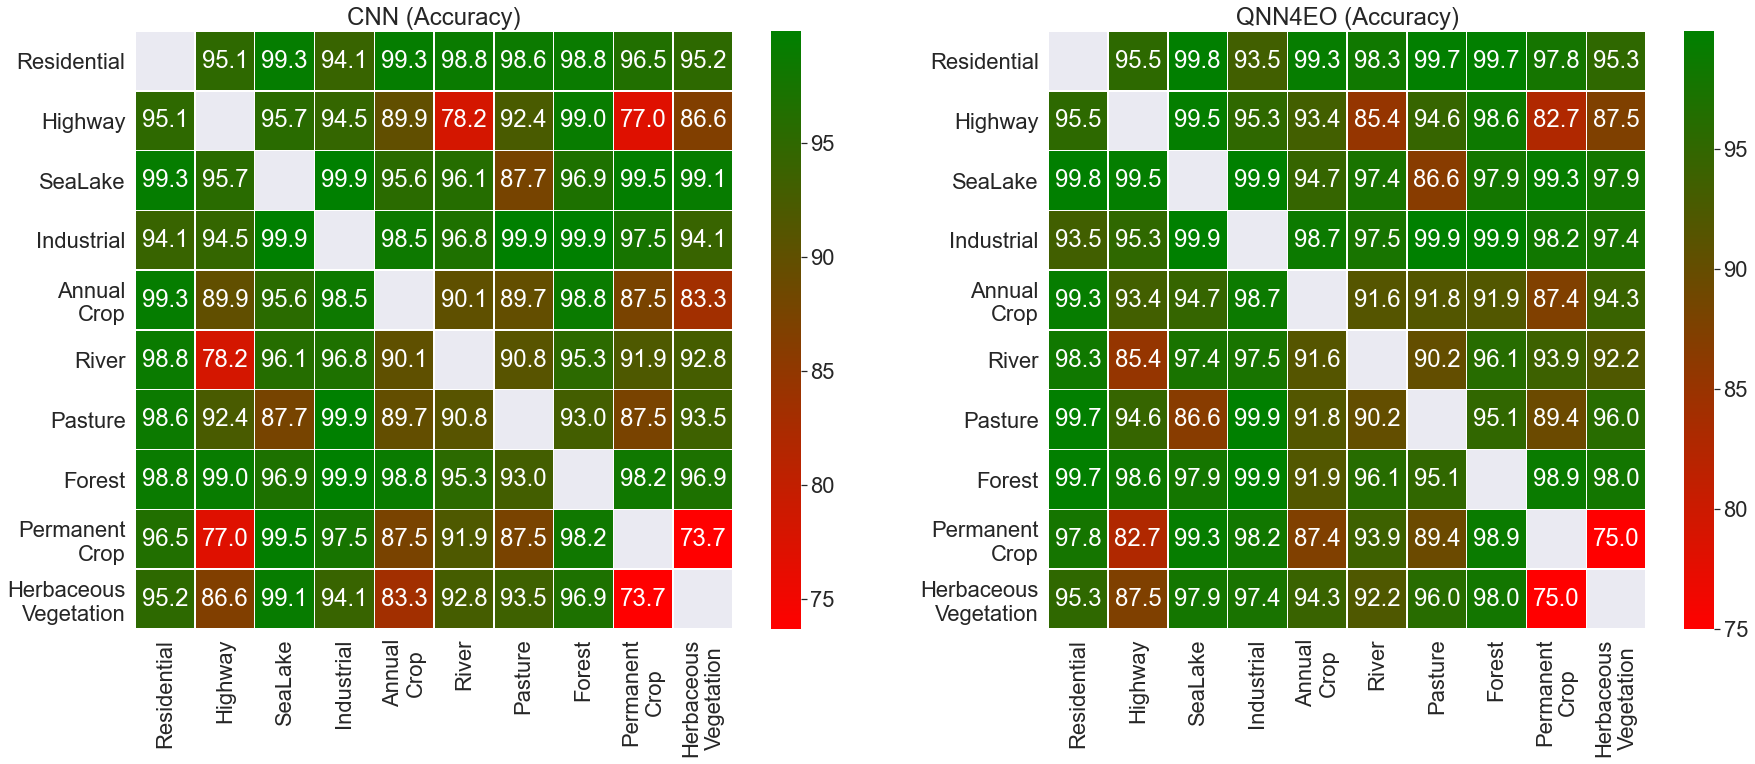

In [40]:
from paper_results import import_results
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from CNN_Classifier import CNN_Classifier
from QNN4EO import QNN4EO


paper_cnn_results, paper_qnn4eo_results, paper_classes_name = import_results()

cmap = LinearSegmentedColormap.from_list(
    name='red-green', 
    colors=['red','green']
)

sns.set(font_scale=2)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 11))
sns.heatmap(paper_cnn_results, linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = paper_classes_name, yticklabels = paper_classes_name, ax = axes[0]).set(title='CNN (Accuracy)')
sns.heatmap(paper_qnn4eo_results, linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = paper_classes_name, yticklabels = paper_classes_name, ax = axes[1]).set(title='QNN4EO (Accuracy)')
plt.show()

In [51]:
cnn_mean_accuracy = np.triu(paper_cnn_results, k=1)
qnn4eo_mean_accuracy = np.triu(paper_qnn4eo_results, k=1)


print('CNN overall accuracy: ',  cnn_mean_accuracy[cnn_mean_accuracy>0].mean())
print('QNN4EO overall accuracy: ',  qnn4eo_mean_accuracy[qnn4eo_mean_accuracy>0].mean())

CNN overall accuracy:  93.63333333333331
QNN4EO overall accuracy:  94.73333333333333
